## import libs/classes and define functions

In [27]:
#import libs
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
import math

# import files 
from DataSet import DataSet
from DataGen import DataGen 
from FixedGP import FixedGP 
from DataGen import DataGen
from MapUpdateNetwork import MapUpdateNetwork

In [28]:
def standardize_vector(vec: np.ndarray) -> np.ndarray:
    """standardize a vector

    Args:
        vec (np.ndarray): the array you want to standardize

    Returns:
        np.ndarray: the standardized vector
    """
    mean = np.mean(vec)
    std = np.std(vec)
    return (vec - mean) / std if std != 0 else vec/vec # avoid divide with zero

In [29]:
def map_plot(my_map, title: str = 'map'):
    """
    Plots a 2D map with color scale and values displayed at each cell.

    This function visualizes a 2D matrix (`my_map`) using a color map, with the values of the 
    matrix displayed at each corresponding location. The color range is automatically scaled 
    to the minimum and maximum values of the matrix, and a color bar is included to indicate 
    the value scale. The function allows customization of the plot title.

    Args:
        my_map (numpy.ndarray): A 2D numpy array to be plotted.
        title (str, optional): The title of the plot. Default is 'map'.

    Returns:
        None: The function displays the plot but does not return anything.
    
    Example:
        map_plot(np.array([[1, 2], [3, 4]]), 'Sample Map')
    """
    # Set up the figure with a fixed size
    plt.figure(figsize=(6, 6))
    
    # Display the map using a color map and scale it according to the minimum and maximum values
    plt.imshow(my_map, cmap='coolwarm', vmin=np.nanmin(my_map), vmax=np.nanmax(my_map))
    
    # Add a color bar to indicate the value scale
    plt.colorbar(label="values")
    
    # Set the title of the plot
    plt.title(title)

    # Loop over each cell of the matrix to display the value in the center of the cell
    for i in range(my_map.shape[0]):
        for j in range(my_map.shape[1]):
            plt.text(j, i, f"{my_map[i, j]:.3g}", ha='center', va='center', color="white", fontsize=8)

    # Show the plot
    plt.show()


In [30]:
def labeled_inputs_plot(train_input, train_label, comb_idx: int = 0, values: bool = False):
    """
    Plots labeled inputs and their corresponding labels with an option to display values.
    
    Args:
        train_input (torch.Tensor): Tensor of input maps with shape (n_combinations, n_features, height, width).
        train_label (torch.Tensor): Tensor of label maps with shape (n_combinations, n_outputs, height, width).
        comb_idx (int): the index of the data you want to plot
        values (bool): If True, display the value of each cell in the plots.
    """
    
    # Define the figure and axes for the subplots
    fig, axes = plt.subplots(2, 3, figsize=(10, 8)) 
    
    # Define the maps for the plots
    maps = [train_input[comb_idx, 0], train_input[comb_idx, 3], train_label[comb_idx, 0], 
            train_input[comb_idx, 1], train_input[comb_idx, 2], train_label[comb_idx, 1]]
    
    # Titles for the plots
    titles = ["mean map (nb_query=4)", "query_y * kernel(query_x)", "mean map (nb_query=5)",
              "std map (nb_query=4)", "kernel(query_x)", "std map (nb_query=5)"]
    
    # Normalize the color scale for the std maps and other maps
    std_maps = [train_input[comb_idx, 1], train_label[comb_idx, 1]]
    other_maps = [train_input[comb_idx, 0], train_input[comb_idx, 2], 
                  train_input[comb_idx, 3], train_label[comb_idx, 0]]
    
    std_min = torch.min(torch.stack(std_maps))
    std_max = torch.max(torch.stack(std_maps))
    other_min = torch.min(torch.stack(other_maps))
    other_max = torch.max(torch.stack(other_maps))
    
    # Plot the maps
    for idx, ax in enumerate(axes.flat):
        # Select colormap and normalization based on the type of map
        if idx in [3, 5]:  # std maps
            cax = ax.imshow(maps[idx], cmap='cividis', vmin=std_min, vmax=std_max)
        else:  # other maps
            cax = ax.imshow(maps[idx], cmap='coolwarm', vmin=other_min, vmax=other_max)
        
        ax.set_title(titles[idx])
        plt.colorbar(cax, ax=ax)
        
        # Add cell values as text if values=True
        if values:
            data = maps[idx].cpu().numpy()  # Convert tensor to numpy array
            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    ax.text(j, i, f"{data[i, j]:.3g}", ha='center', va='center', 
                            color="white", fontsize=6)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


## Get the data 

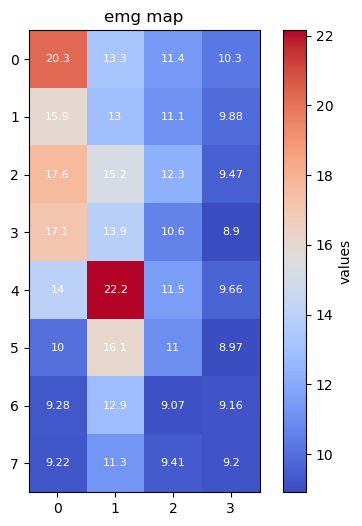

In [31]:
# Load dataset and extract relevant data
ds = DataSet('data/', 'rat', 'rat2_M1_190617.mat', 'rat2')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

# Extract relevant variables from the dataset
ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
output = sorted_respMean[:, 4]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

# Initialize an empty map for EMG values, with shape based on the maximum x and y positions
map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

# Loop over each channel and assign its response mean value to the corresponding position in the EMG map
for i in range(ch2xy.shape[0]):
    # Convert the (x, y) position to zero-based indices and set the EMG value at that position
    map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

# Plot the generated EMG map using the previously defined map_plot function
map_plot(map_emg, 'emg map')


## Transform data for the NN

In [32]:
dg = DataGen(map_emg)
dg.generate_pre_labeled_inputs(name='1st_test', nb_queries=5, nb_comb=10, 
                               kernel_type='Mat52', noise_std=0.1, 
                               output_std=3, lengthscale=[1.*1/7, 1.*1/3])
dg.format_labeled_inputs(name='1st_test')

These pre-labeled inputs were made with these parameters:
 name: 1st_test
 nb_queries: 5
 nb_comb: 10
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


In [33]:
# Load the saved data from a .pth file using PyTorch
loaded_data = torch.load('dataset/og_'+'1st_test'+'.pth', weights_only=True)  
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
train_input = loaded_data["train_input"]  # The input data for training
train_label = loaded_data["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These labeled inputs were made with these parameters:
 name: 1st_test
 nb_queries: 5
 nb_comb: 10
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


### Visualize the labeled data 

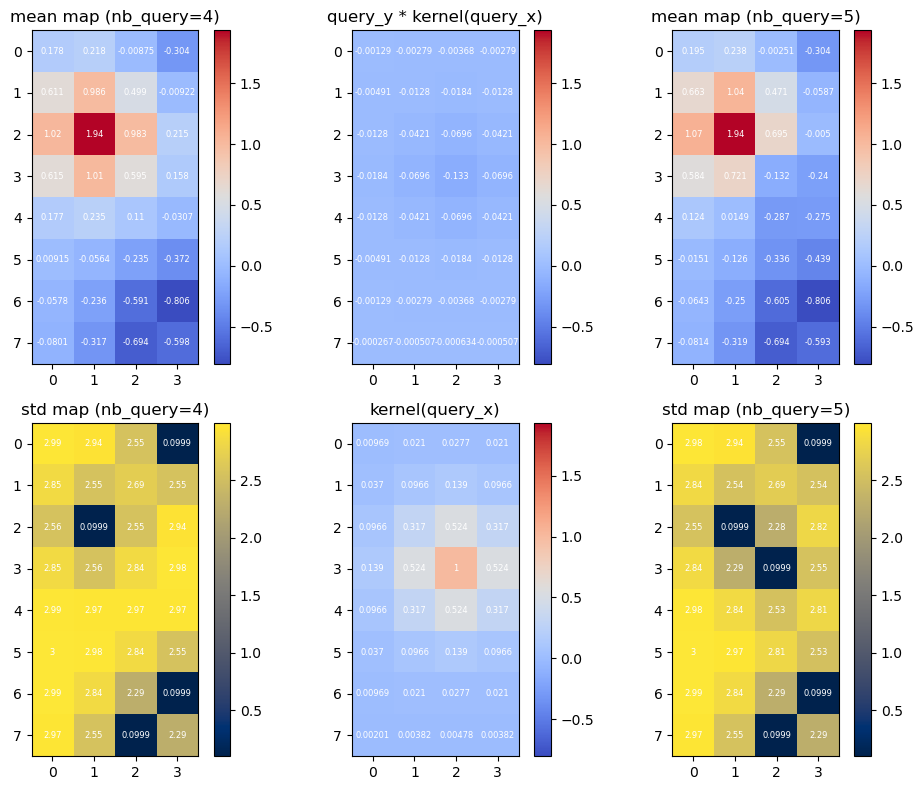

In [42]:
labeled_inputs_plot(train_input=train_input, train_label=train_label, comb_idx=5, values=True)

## NN model

In [37]:
# Initialize the model
model = MapUpdateNetwork(in_channels=4, out_channels=2)

# a image tensor is represented like this : [batch_size, channels, height, width]

# Example input images and target image (each 8x4, 1 channel)
img1, img2, img3, img4 = torch.randn(1, 1, 8, 4), torch.randn(1, 1, 8, 4), torch.randn(1, 1, 8, 4), torch.randn(1, 1, 8, 4)
target = torch.randn(1, 2, 8, 4)  # Target image for supervised learning

# Calculate the model output
output = model(img1, img2, img3, img4)

print(img1.shape)
print(output.shape)

# Define the loss function (Mean Squared Error)
loss_fn = nn.MSELoss()
loss = loss_fn(output, target)

# Print the loss value to verify functionality
print("Loss:", loss.item())

torch.Size([1, 1, 8, 4])
torch.Size([1, 2, 8, 4])
Loss: 1.253474235534668
